In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Description des données

Les données cliniques ont été fournies au format tabulé (.tsv).  
Une attention particulière a été portée au séparateur lors de l’import afin d’éviter des erreurs de parsing.


In [2]:
#chargement des données
df = pd.read_csv('aml_tcga_gdc_clinical_data.csv', sep="\t") # séparateur de tabulations


#Aperçu des premières lignes
print("Aperçu des premières lignes :")
print(df.head())

#Dimensions et types de colonnes
print("\nDimensions du DataFrame :")
print(df.shape)

print("\nTypes des colonnes :")
print(df.dtypes)

#liste des colonnes
print("\nColonnes disponibles :")
print(df.columns.tolist())

Aperçu des premières lignes :
       Study ID    Patient ID        Sample ID  Diagnosis Age  Biopsy Site  \
0  aml_tcga_gdc  TCGA-AB-2802  TCGA-AB-2802-03             50  Bone Marrow   
1  aml_tcga_gdc  TCGA-AB-2803  TCGA-AB-2803-03             61  Bone Marrow   
2  aml_tcga_gdc  TCGA-AB-2804  TCGA-AB-2804-03             30  Bone Marrow   
3  aml_tcga_gdc  TCGA-AB-2805  TCGA-AB-2805-03             76  Bone Marrow   
4  aml_tcga_gdc  TCGA-AB-2806  TCGA-AB-2806-03             46  Bone Marrow   

              Cancer Type    Cancer Type Detailed  \
0  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
1  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
2  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
3  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
4  Acute Myeloid Leukemia  Acute Myeloid Leukemia   

   Last Communication Contact from Initial Pathologic Diagnosis Date  \
0                                                NaN                   
1                                     

## Analyse des valeurs manquantes

Certaines variables présentent un nombre important de valeurs manquantes, notamment les variables temporelles (dates de contact, date de décès) et certaines variables biologiques (TMB, mutation count).  
Ces absences sont cohérentes avec le contexte clinique (patients vivants, examens non réalisés) et seront prises en compte lors de l’étape de prétraitement.

Les valeurs manquantes sont inspectées variable par variable afin d’évaluer la qualité des données et d’anticiper les stratégies de prétraitement.


In [3]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Valeurs manquantes par colonne :")
print(missing_values)


Valeurs manquantes par colonne :
Last Communication Contact from Initial Pathologic Diagnosis Date    132
Mutation Count                                                       129
TMB (nonsynonymous)                                                  128
Death from Initial Pathologic Diagnosis Date                          80
Overall Survival (Months)                                             12
Ethnicity Category                                                     3
Race Category                                                          2
Patient Primary Tumor Site                                             1
Biopsy Site                                                            1
Study ID                                                               0
Birth from Initial Pathologic Diagnosis Date                           0
Cancer Type                                                            0
Diagnosis Age                                                          0
Is FFPE           

C:\Users\Emma\AppData\Local\Temp\ipykernel_944\2803939711.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.values, y=missing_values.index, palette="pastel", edgecolor="black")


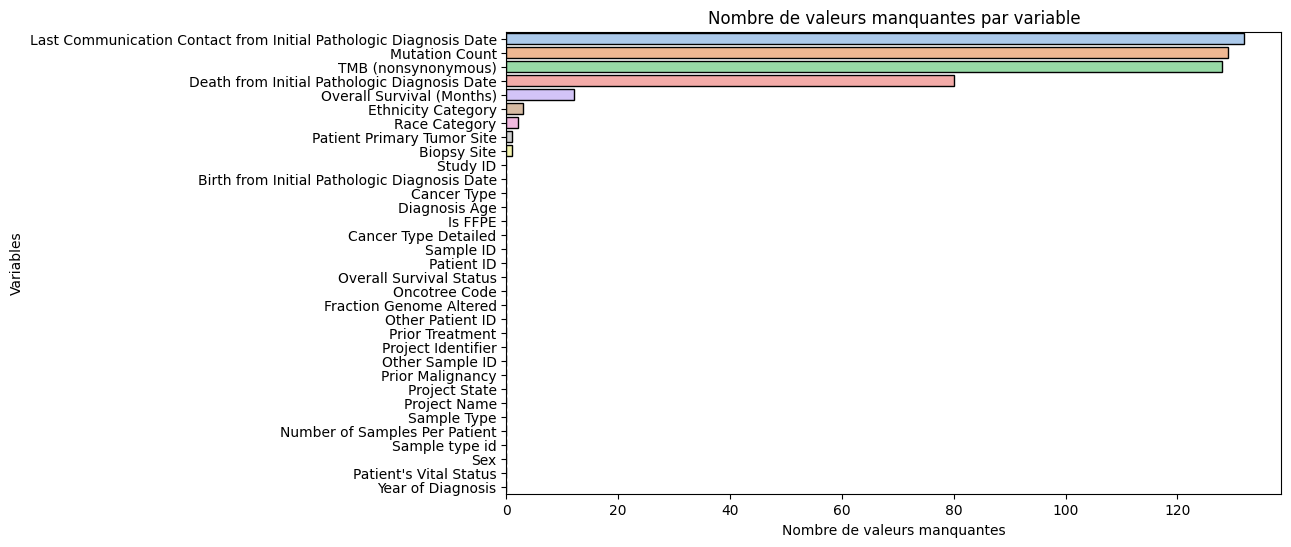

In [4]:
# représentation graphique des valeurs manquantes
plt.figure(figsize=(10,6))
sns.barplot(x=missing_values.values, y=missing_values.index, palette="pastel", edgecolor="black")
plt.title("Nombre de valeurs manquantes par variable")
plt.xlabel("Nombre de valeurs manquantes")
plt.ylabel("Variables")
plt.show()

In [5]:
# Remplacement des valeurs manquantes pour "Overall Survival (Months)" par la moyenne
df["Overall Survival (Months)"] = df["Overall Survival (Months)"].fillna(df["Overall Survival (Months)"].mean())


## Nettoyage et suppression des colonnes non pertinentes

In [6]:
cols_to_drop = [
    'Study ID', 'Patient ID', 'Sample ID',  
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Death from Initial Pathologic Diagnosis Date', 'Ethnicity Category',
        'Oncotree Code','Other Patient ID', 'Other Sample ID', 'Patient Primary Tumor Site',
       'Project Identifier',
       'Project Name', 'Project State', 'Race Category',
       'Number of Samples Per Patient', 'Sample Type', 'Sample type id', 'TMB (nonsynonymous)', 'Mutation Count',
       'Is FFPE', 'Biopsy Site', 'Cancer Type', 'Cancer Type Detailed', 'Overall Survival Status', 'Overall Survival (Months)'
        ]
      

df = df.drop(columns=cols_to_drop, errors="ignore")


## Encodage des variables catégorielles

In [7]:
# Encodage des variables qualitatives (passage en category)
for col in [
    "Sex", "Patient's Vital Status"]:
    df[col] = df[col].astype("category")

print(df.dtypes)

Diagnosis Age                 int64
Fraction Genome Altered     float64
Prior Malignancy               bool
Prior Treatment                bool
Sex                        category
Patient's Vital Status     category
Year of Diagnosis             int64
dtype: object


## Analyse univariée

### Variable dépendante (cible)

In [8]:
# Distribution de la variable cible (target)
target_counts = df["Patient's Vital Status"].value_counts(normalize=True)
print("Distribution de la variable cible :")
print(target_counts)

Distribution de la variable cible :
Patient's Vital Status
Dead     0.665
Alive    0.335
Name: proportion, dtype: float64


La variable cible présente un certain déséquilibre, ce qui devra être pris en compte lors de l’évaluation des modèles. La distribution de la variable cible montre un déséquilibre de classes modéré, avec environ 66,5 % de patients décédés et 33,5 % de patients vivants.
Ce déséquilibre sera pris en compte lors de l’évaluation des modèles, notamment à travers des métriques adaptées au contexte clinique.

La variable cible est déséquilibrée, ce qui nécessite des métriques adaptées (recall, AUC).

### Variables quantitatives (numérique)

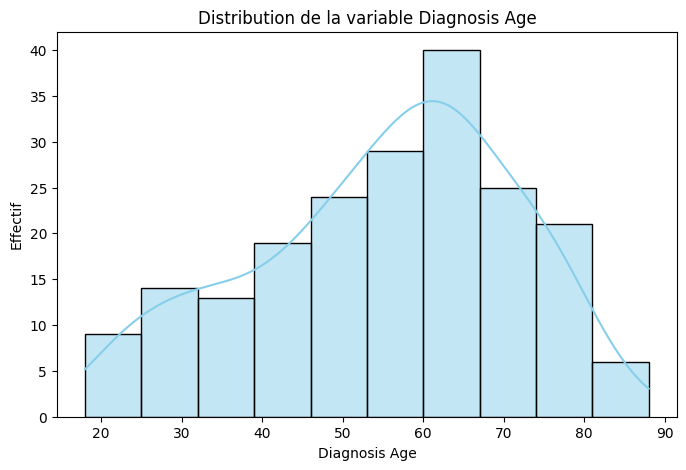

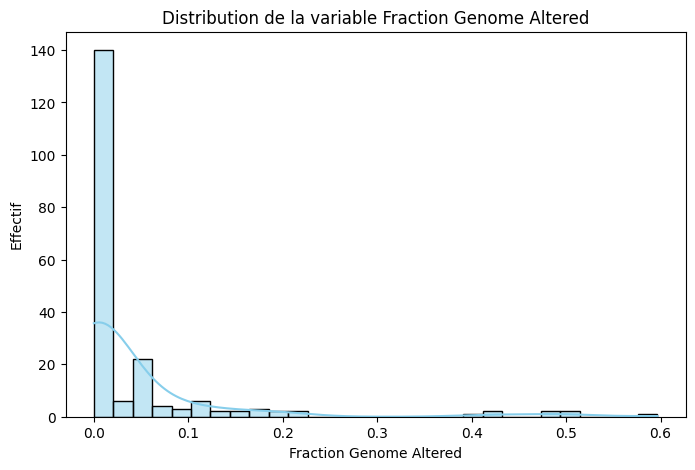

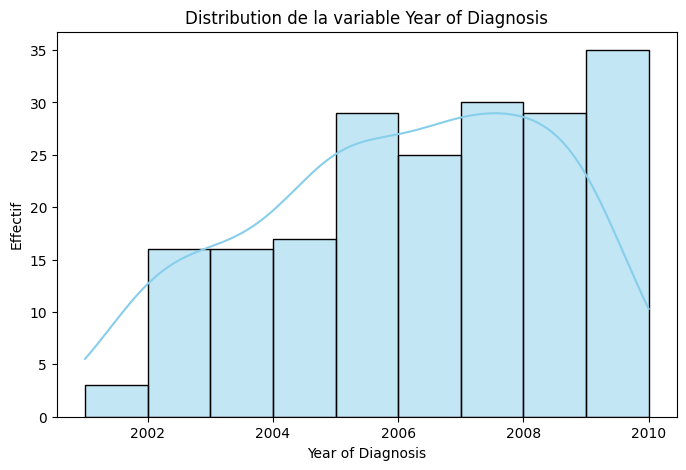

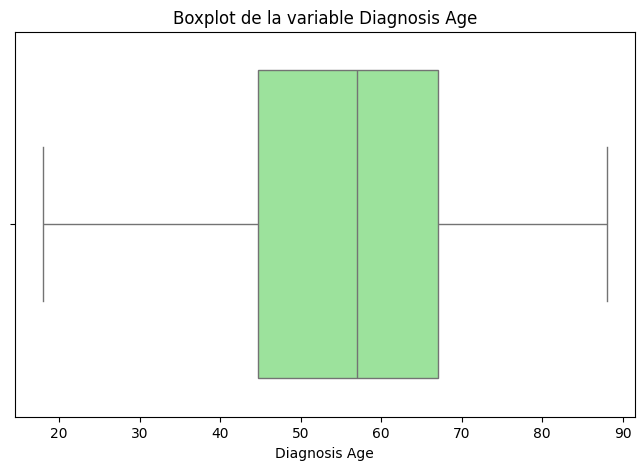

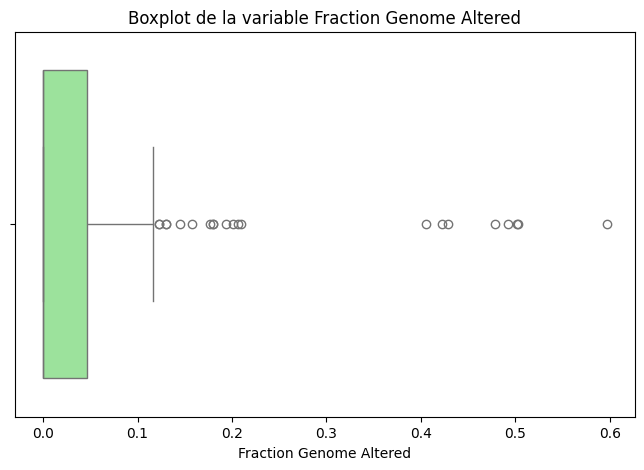

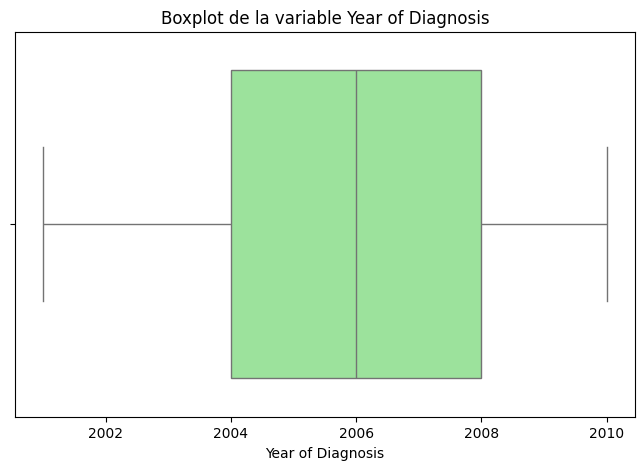

In [9]:
# Sélection des variables numériques
num_vars = df.select_dtypes(include=['float64','int64']).columns

# Histogrammes
for col in num_vars : 
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, color="skyblue")
    plt.title(f'Distribution de la variable {col}')
    plt.xlabel(col)
    plt.ylabel("Effectif")
    plt.show()

# Boxplots
for col in num_vars:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df[col], color="lightgreen")
    plt.title(f'Boxplot de la variable {col}')
    plt.show()

## Suppresion des outliers

In [10]:
# Détection des outliers par IQR (Q15-Q85)
Q1 = df[num_vars].quantile(0.15)
Q3 = df[num_vars].quantile(0.85)
IQR = Q3 - Q1

df_clean = df[~((df[num_vars] < (Q1 - 1.5 * IQR)) |(df[num_vars] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Nombre d'observations après suppresion des outliers : {df_clean.shape[0]}")

Nombre d'observations après suppresion des outliers : 188


## Variables catégorielles

C:\Users\Emma\AppData\Local\Temp\ipykernel_944\2769285798.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


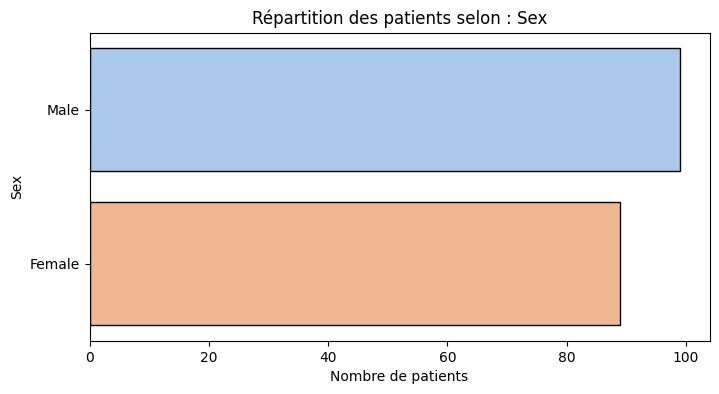

C:\Users\Emma\AppData\Local\Temp\ipykernel_944\2769285798.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


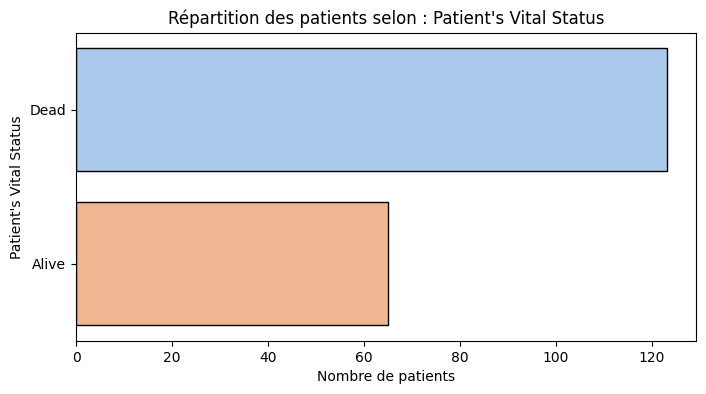

In [11]:
# Sélection des variables catégorielles
cat_vars = df_clean.select_dtypes(include=['category']).columns

# Countplot
for col in cat_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(
        y=col,
        data=df_clean,
        order=df_clean[col].value_counts().index,
        palette="pastel",
        edgecolor="black"
    )
    plt.title(f"Répartition des patients selon : {col}")
    plt.xlabel("Nombre de patients")
    plt.ylabel(col)
    plt.show()

## Analyse bivariée

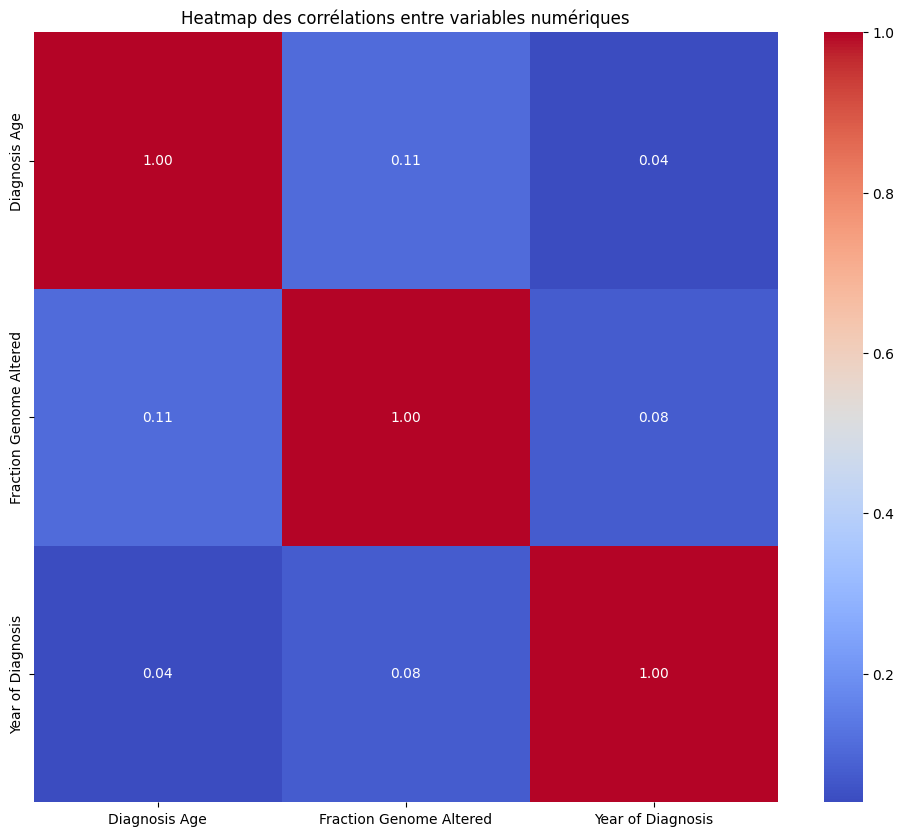

In [12]:
# Corrélation entre variables numériques
plt.figure(figsize=(12,10))
sns.heatmap(df_clean[num_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des corrélations entre variables numériques")
plt.show()

C:\Users\Emma\AppData\Local\Temp\ipykernel_944\2411666029.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Patient's Vital Status", y=col, data=df_clean, palette="pastel")


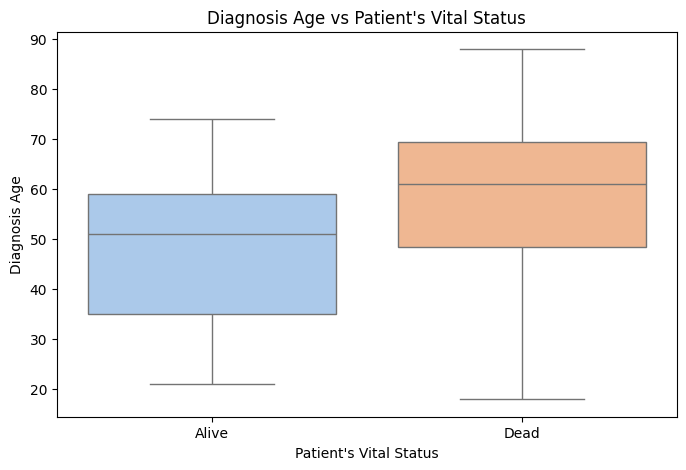

C:\Users\Emma\AppData\Local\Temp\ipykernel_944\2411666029.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Patient's Vital Status", y=col, data=df_clean, palette="pastel")


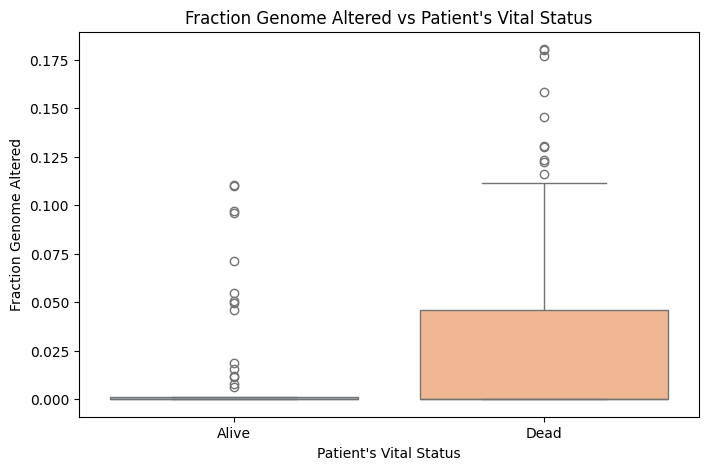

C:\Users\Emma\AppData\Local\Temp\ipykernel_944\2411666029.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Patient's Vital Status", y=col, data=df_clean, palette="pastel")


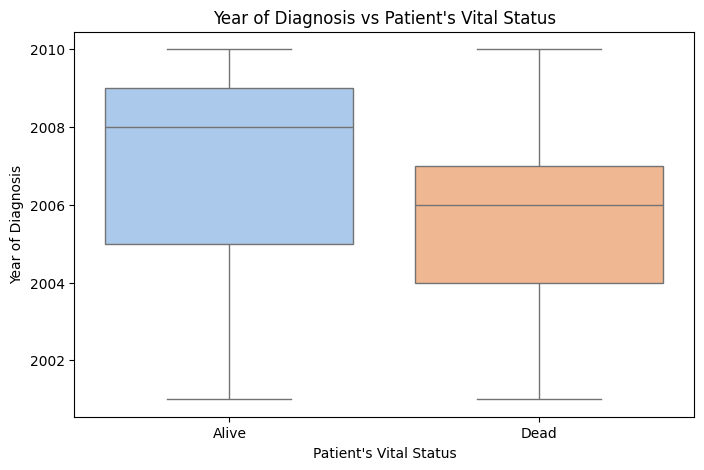

In [13]:
# Boxplots des variables numériques vs variable cible
for col in num_vars:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="Patient's Vital Status", y=col, data=df_clean, palette="pastel")
    plt.title(f"{col} vs Patient's Vital Status")
    plt.show()

In [14]:
# Export du dataset nettoyé
df_clean.to_csv("df_clean.csv", index=False)
print("df_clean sauvegardé dans data/processed/")

df_clean sauvegardé dans data/processed/
